In [1]:
import os
import numpy as np
from collections import Counter
from IPython.utils.capture import capture_output
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from midi_util import read_midi, produce_song

Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
path = os.getcwd() + "/data/"
print("Data path: ", path)

midi_file_names = [i for i in os.listdir(path) if i.endswith(".mid")]
print("# of Files Found: ", len(midi_file_names))

notes = []
durations = []
#hide output, gives many long annoying warnings
with capture_output():
    note_data_by_file = []
    duration_data_by_file = []

    for fn in midi_file_names:
        notes, durations = read_midi(path + fn, allow_chords=False)
        note_data_by_file.append(notes)
        duration_data_by_file.append(durations)

    note_data_by_file = np.array(note_data_by_file)
    duration_data_by_file = np.array(duration_data_by_file)

#print(note_data_by_file)
print(note_data_by_file.shape)
#print(duration_data_by_file)
print(duration_data_by_file.shape)

Data path:  /Users/danielrjohnson/Documents/OneDrive/Programming/AIO/Music-Generation/data/
# of Files Found:  35
(35,)
(35,)


In [3]:
#list comp to flatten
flattened_note_data = [element for note_ in note_data_by_file for element in note_]
print("# of Notes Total: ", len(flattened_note_data))

all_unique_notes = list(set(flattened_note_data))
print("# of Unique Notes: ", len(all_unique_notes))

# of Notes Total:  29748
# of Unique Notes:  87


In [4]:
note_counts = dict(Counter(flattened_note_data))

MIN_COUNT = 25
frequent_notes = [note_ for note_, count in note_counts.items() if count >= MIN_COUNT]
print("# of Notes Occurring At Least", MIN_COUNT, "Times: ", len(frequent_notes))

# of Notes Occurring At Least 25 Times:  70


In [5]:
freq_note_data = [list(filter(lambda x: x in frequent_notes, midi_data)) for midi_data in note_data_by_file]
freq_note_data = np.array(freq_note_data, dtype=object)

In [6]:
n_timesteps = 32
X, y_note, y_duration = [], [], []

for notes_of_file, durations_of_file in zip(note_data_by_file, duration_data_by_file): #freq_note_data:
    for i in range(0, len(notes_of_file) - n_timesteps):
        # (n_timesteps) length note sequence
        X.append([notes_of_file[i:i + n_timesteps], durations_of_file[i:i + n_timesteps]])
        # the note following that sequence
        y_note.append(notes_of_file[i + n_timesteps])
        # the duration of the note following that sequence
        y_duration.append(durations_of_file[i + n_timesteps])


X = np.array(X)
y_note = np.array(y_note)
y_duration = np.array(y_duration)

In [7]:
print(np.unique(y_note))

['A0' 'A1' 'A2' 'A3' 'A4' 'A5' 'A6' 'A7' 'B-0' 'B-1' 'B-2' 'B-3' 'B-4'
 'B-5' 'B-6' 'B-7' 'B1' 'B2' 'B3' 'B4' 'B5' 'B6' 'B7' 'C#1' 'C#2' 'C#3'
 'C#4' 'C#5' 'C#6' 'C#7' 'C1' 'C2' 'C3' 'C4' 'C5' 'C6' 'C7' 'C8' 'D1' 'D2'
 'D3' 'D4' 'D5' 'D6' 'D7' 'E-1' 'E-2' 'E-3' 'E-4' 'E-5' 'E-6' 'E-7' 'E1'
 'E2' 'E3' 'E4' 'E5' 'E6' 'E7' 'F#1' 'F#2' 'F#3' 'F#4' 'F#5' 'F#6' 'F#7'
 'F1' 'F2' 'F3' 'F4' 'F5' 'F6' 'F7' 'G#1' 'G#2' 'G#3' 'G#4' 'G#5' 'G#6'
 'G#7' 'G1' 'G2' 'G3' 'G4' 'G5' 'G6' 'G7']


In [8]:
unique_x_note = list(set(X[:, 0].ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x_note))
x_seq_note = np.array([[x_note_to_int[note] for note in row] for row in X[:, 0]])

unique_x_dur = list(set(X[:, 1].ravel()))
x_dur_to_int = dict((duration, number) for number, duration in enumerate(unique_x_dur))
x_seq_dur = np.array([[x_dur_to_int[duration] for duration in row] for row in X[:, 1]])

# ([Nx32x1], [Nx32x1]) -> ([Nx32x2])
x_seq_combined = np.array(
    [ [ [note, duration] for note, duration in zip(row_note, row_dur) ]
        for row_note, row_dur in zip(x_seq_note, x_seq_dur) ]
)
print("combined note and duration array shape:", x_seq_combined.shape)

unique_y_note = list(set(y_note))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y_note)) 
y_seq_note = np.array([y_note_to_int[note] for note in y_note])

unique_y_duration = list(set(y_duration))
y_dur_to_int = dict((duration_, number) for number, duration_ in enumerate(unique_y_duration))
y_seq_dur = np.array([y_dur_to_int[duration] for duration in y_duration])

combined note and duration array shape: (28915, 32, 2)


In [9]:
x_tr_note, x_val_note, y_tr_note, y_val_note = train_test_split(x_seq_combined, y_seq_note, test_size=0.2, random_state=0)
x_tr_dur, x_val_dur, y_tr_dur, y_val_dur = train_test_split(x_seq_combined, y_seq_dur, test_size=0.2, random_state=0)

In [10]:
inputs = Input((n_timesteps, 2))
x = LSTM(128)(inputs)
x = Dense(128, activation="relu")(x)
output = Dense(len(unique_x_note), activation="softmax")(x)

model_note = tf.keras.Model(inputs, output)

model_note.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model_note.summary()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 2)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               67072     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 87)                11223     
Total params: 94,807
Trainable params: 94,807
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Epoch 1/50
181/181 [==============================] - 5s 23ms/step - loss: 4.1918 - val_loss: 3.9318

Epoch 00001: val_loss improved from inf to 3.93182, saving model to models/best_model_note.h5
Epoch 2/50
181/181 [==============================] - 4s 20ms/step - loss: 3.8874 - val_loss: 3.8795

Epoch 00002: val_loss improved from 3.93182 to 3.87948, saving model to models/best_model_note.h5
Epoch 3/50
181/181 [==============================] - 4s 19ms/step - loss: 3.8638 - val_loss: 3.8686

Epoch 00003: val_loss improved from 3.87948 to 3.86861, saving model to models/best_model_note.h5
Epoch 4/50
181/181 [==============================] - 5s 29ms/step - loss: 3.8551 - val_loss: 3.8583

Epoch 00004: val_loss improved from 3.86861 to 3.85834, saving model to models/best_model_note.h5
Epoch 5/50
181/181 [==============================] - 4s 23ms/step - loss: 3.8474 - val_loss: 3.8526

Epoch 00005: val_loss

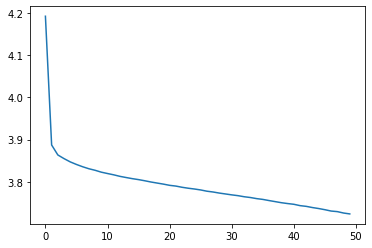

In [11]:
mc = ModelCheckpoint('models/best_model_note.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

device = tf.device('/device:GPU:0') if tf.config.list_physical_devices("GPU") else tf.device('/device:CPU:0')

with device:
    history = model_note.fit(x=x_tr_note, y=y_tr_note,
                        batch_size=128, epochs=50, 
                        validation_data=(x_val_note, y_val_note),
                        verbose=1, callbacks=[mc]
    )
plt.plot(history.history['loss'])
plt.show()

In [12]:
inputs = Input((n_timesteps, 2))
x = LSTM(128)(inputs)
x = Dense(128, activation="relu")(x)
output = Dense(len(unique_x_dur), activation="softmax")(x)

model_dur = tf.keras.Model(inputs, output)

model_dur.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))
model_dur.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 2)]           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               67072     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 84,874
Trainable params: 84,874
Non-trainable params: 0
_________________________________________________________________


In [13]:
mc = ModelCheckpoint('models/best_model_dur.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

device = tf.device('/device:GPU:0') if tf.config.list_physical_devices("GPU") else tf.device('/device:CPU:0')

with device:
    history = model_dur.fit(x=x_tr_dur, y=y_tr_dur,
                        batch_size=128, epochs=50, 
                        validation_data=(x_val_dur, y_val_dur),
                        verbose=1, callbacks=[mc]
    )
plt.plot(history.history['loss'])
plt.show()

Epoch 1/50
181/181 [==============================] - 5s 23ms/step - loss: 1.7959 - val_loss: 1.6600

Epoch 00001: val_loss improved from inf to 1.65996, saving model to models/best_model_dur.h5
Epoch 2/50
181/181 [==============================] - 4s 20ms/step - loss: 1.6462 - val_loss: 1.6417

Epoch 00002: val_loss improved from 1.65996 to 1.64166, saving model to models/best_model_dur.h5
Epoch 3/50
181/181 [==============================] - 4s 21ms/step - loss: 1.6360 - val_loss: 1.6370

Epoch 00003: val_loss improved from 1.64166 to 1.63704, saving model to models/best_model_dur.h5
Epoch 4/50
181/181 [==============================] - 4s 22ms/step - loss: 1.6329 - val_loss: 1.6362

Epoch 00004: val_loss improved from 1.63704 to 1.63622, saving model to models/best_model_dur.h5
Epoch 5/50
181/181 [==============================] - 4s 21ms/step - loss: 1.6314 - val_loss: 1.6352

Epoch 00005: val_loss improved from 1.63622 to 1.63523, saving model to models/best_model_dur.h5
Epoch 6/5

In [ ]:
# initial_note_sequence = x_val_note[np.random.randint(0, len(x_val_note))]
# initial_duration_sequence = x_val_dur[np.random.randint(0, len(x_val_dur))]
initial_sequence = x_val_note[np.random.randint(0, len(x_val_note))]
x_int_to_note = {v: k for k, v in x_note_to_int.items()}
x_int_to_dur = {v: k for k, v in x_dur_to_int.items()}

produce_song(initial_sequence, x_int_to_note, x_int_to_dur, 
            n_notes=50, midi_file_path="songs/song.mid")